<!-- ABSTRACT -->

With this script, we evaluate the ensembles and check how well they perform. The result is a plot of the uncertainty of the model's predictions. However, it seems that the uncertainty is not very high.

In [1]:
import os
import sys
import numpy as np
import json
import joblib
import geopandas as gpd
import torch
import tqdm
import help_functions as hf

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from gnn_architecture import MyGnn, mc_dropout_predict
import help_functions as hf

ERROR 1: PROJ: proj_create_from_database: Open of /opt/anaconda3/envs/chenhao-gnn/share/proj failed


In [2]:
# Paths
runs_path = '../../data/runs_01_2025/'
ensembles = ["ensemble_1",
             "ensemble_2",
             "ensemble_3",
             "ensemble_4_lrz",
             "ensemble_5"]

# Dropout for Ensembles
use_dropout = [False,
               False,
               False,
               True,
               True]

districts = gpd.read_file("../../data/visualisation/districts_paris.geojson")
base_case_path = '../../data/links_and_stats/pop_1pct_basecase_average_output_links.geojson'

# GNN Parameters
point_net_conv_layer_structure_local_mlp = "256"
point_net_conv_layer_structure_global_mlp = "512"
gat_conv_layer_structure = "128,256,512"
predict_mode_stats = False
in_channels = 5
out_channels = 1

point_net_conv_layer_structure_local_mlp = [int(x) for x in point_net_conv_layer_structure_local_mlp.split(',')]
point_net_conv_layer_structure_global_mlp = [int(x) for x in point_net_conv_layer_structure_global_mlp.split(',')]
gat_conv_layer_structure = [int(x) for x in gat_conv_layer_structure.split(',')]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fct = torch.nn.MSELoss().to(dtype=torch.float32).to(device)

In [3]:
# Load test set and scalers
# Same for each ensemble with seed=42

ensemble_path = os.path.join(runs_path, ensembles[0])
data_created_during_training = os.path.join(ensemble_path, 'data_created_during_training/')

# Load scalers
scaler_x = joblib.load(data_created_during_training + 'test_x_scaler.pkl')
scaler_pos = joblib.load(data_created_during_training + 'test_pos_scaler.pkl')

# Load the test dataset created during training
test_set_dl = torch.load(data_created_during_training + 'test_dl.pt')

# Load the DataLoader parameters
with open(data_created_during_training + 'test_loader_params.json', 'r') as f:
    test_set_dl_loader_params = json.load(f)
    
# Remove or correct collate_fn if it is incorrectly specified
if 'collate_fn' in test_set_dl_loader_params and isinstance(test_set_dl_loader_params['collate_fn'], str):
    del test_set_dl_loader_params['collate_fn']  # Remove it to use the default collate function
    
test_set_loader = torch.utils.data.DataLoader(test_set_dl, **test_set_dl_loader_params)

In [4]:
def load_ensemble(ensemble, model_path, use_dropout):

    model = MyGnn(in_channels=in_channels, out_channels=out_channels,
                  point_net_conv_layer_structure_local_mlp=point_net_conv_layer_structure_local_mlp, 
                  point_net_conv_layer_structure_global_mlp = point_net_conv_layer_structure_global_mlp,
                  gat_conv_layer_structure=gat_conv_layer_structure,
                  use_dropout=use_dropout,
                 verbose=False)
    
    model = model.to(device)
    model.load_state_dict(torch.load(model_path))

    return model

In [5]:
for i, ensemble in enumerate(ensembles):

    model_path = os.path.join(runs_path, ensemble, 'trained_model/model.pth')
    model = load_ensemble(ensemble, model_path, use_dropout[i])
    
    test_loss, r_squared, actual_vals, predictions, baseline_loss = hf.validate_model_on_test_set(model, test_set_loader.dataset, loss_fct, device)

    print(f"\n{ensemble}:")
    print(f"Test Loss: {test_loss}")
    print(f"R-squared: {r_squared}")
    print(f"Baseline Loss: {baseline_loss}")

/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")



ensemble_1:
Test Loss: 25.42597733737473
R-squared: 0.7585934400558472
Baseline Loss: 105.32430267333984

ensemble_2:
Test Loss: 37.187754305117686
R-squared: 0.6469213962554932
Baseline Loss: 105.32430267333984

ensemble_3:
Test Loss: 40.130083951709075
R-squared: 0.6189855337142944
Baseline Loss: 105.32430267333984

ensemble_4_lrz:
Test Loss: 37.272034043726364
R-squared: 0.6461212635040283
Baseline Loss: 105.32430267333984

ensemble_5:
Test Loss: 37.83286065515915
R-squared: 0.6407964825630188
Baseline Loss: 105.32430267333984


### Next, we will look at the test set and visualize the performance of the ensembles.

In [6]:
links_base_case = gpd.read_file(base_case_path, crs="EPSG:4326")

In [ ]:
# Visualize performance of individual models

fixed_norm_max = 8
i = 0

print(f"Results for sample {i}\n")

test_data = test_set_loader.dataset[i]
test_x = test_set_loader.dataset[i].x
test_x = test_x.to('cpu')

for i, ensemble in enumerate(ensembles):

    print(f"Results for {ensemble}:")

    model_path = os.path.join(runs_path,ensemble,'trained_model/model.pth')
    model = load_ensemble(ensemble, model_path, use_dropout[i])

    test_loss, r_squared, actual_vals, predictions, baseline_loss = hf.validate_model_on_test_set(model, test_data, loss_fct, device)

    print(f"Test Loss: {test_loss}")
    print(f"R-squared: {r_squared}")
    print(f"Baseline Loss: {baseline_loss}")

    inversed_x = scaler_x.inverse_transform(test_x)

    # print(f"Length of original_gdf: {len(links_base_case)}")
    # print(f"Length of inversed_x: {inversed_x.shape[0]}")

    gdf_with_og_values = hf.data_to_geodataframe_with_og_values(data=test_data, original_gdf=links_base_case, predicted_values=predictions, inversed_x=inversed_x, use_all_features=False)
    gdf_with_og_values['capacity_reduction_rounded'] = gdf_with_og_values['capacity_reduction'].round(decimals=3)
    gdf_with_og_values['highway'] = gdf_with_og_values['highway'].map(hf.highway_mapping)

    print("\nPredicted values:")
    hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_predicted", 
                            save_it=False, number_to_plot=i, zone_to_plot = "this zone", is_predicted=True, alpha=0, 
                            use_fixed_norm=True, fixed_norm_max = fixed_norm_max,
                            known_districts = False, buffer = 0.0005, districts_of_interest=None)

    print("Actual values:")
    hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_actual", save_it=False, 
                            number_to_plot=i, zone_to_plot = "this zone",is_predicted=False,alpha=10,
                            use_fixed_norm=True, fixed_norm_max = fixed_norm_max,
                            known_districts = False, buffer = 0.0005, districts_of_interest=None)

In [9]:
def ensemble_predict(model, data, device):
    
    predictions = []

    with torch.no_grad():
        for i, ensemble in enumerate(ensembles):
            
            model_path = os.path.join(runs_path, ensemble, 'trained_model/model.pth')
            model = load_ensemble(ensemble, model_path, use_dropout[i])
            model.eval()

            pred = model(data.to(device))
            if isinstance(pred, tuple):  # If multiple outputs (e.g., mode_stats)
                pred = pred[0]
            predictions.append(pred.cpu().numpy())  # Collect predictions

    # Stack predictions and calculate statistics
    predictions = np.stack(predictions, axis=0)  # Shape: (num_ensembles, num_predictions)
    mean_prediction = predictions.mean(axis=0)  # Mean prediction
    uncertainty = predictions.std(axis=0)       # Uncertainty (standard deviation)

    return mean_prediction, uncertainty

Ensemble uncertainty for sample 32:


/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


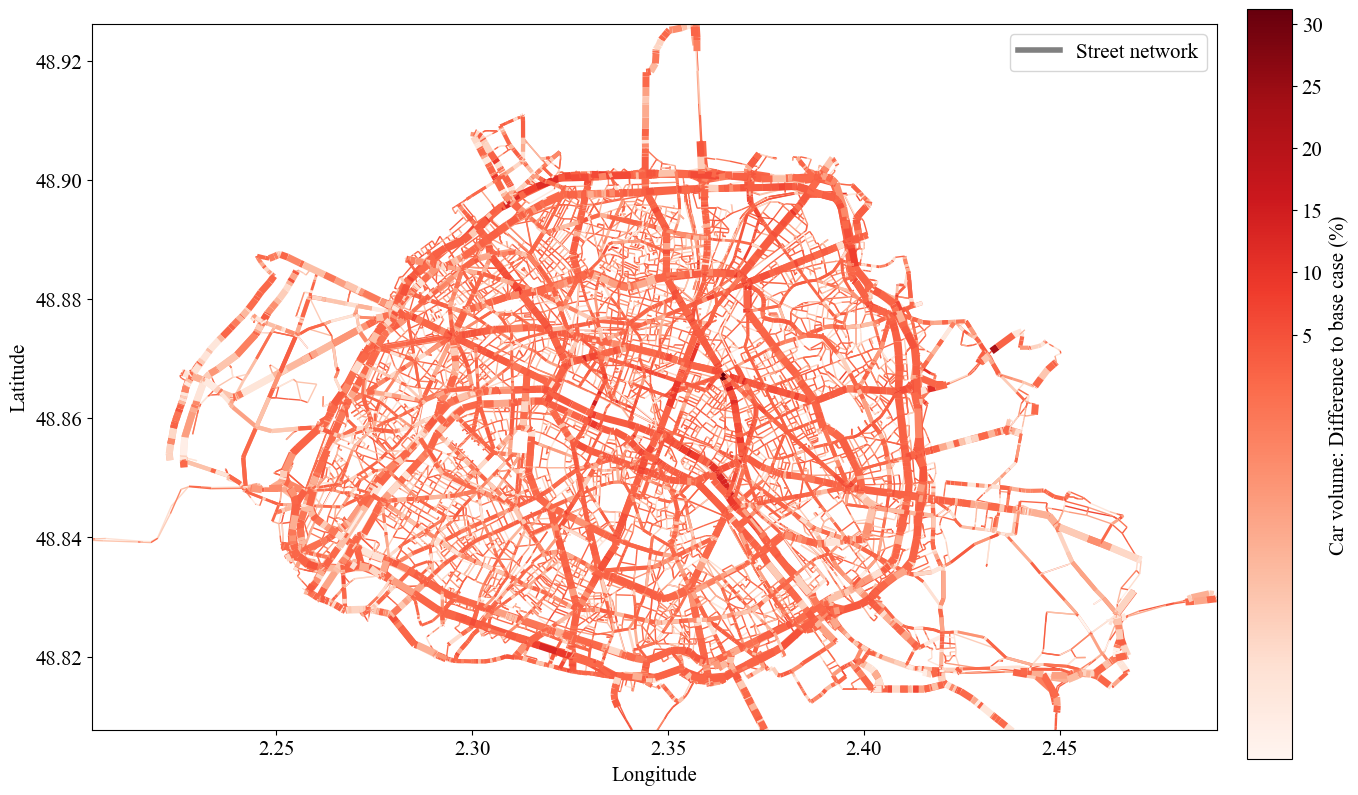

In [10]:
# Ensemble uncertainty on single sample

i = 32
print(f"Ensemble uncertainty for sample {i}:")

test_data = test_set_loader.dataset[i]
test_x = test_set_loader.dataset[i].x
test_x = test_x.to('cpu')

inversed_x = scaler_x.inverse_transform(test_x)
mean_predictions, uncertainties = ensemble_predict(model, test_data, device=device)

gdf_with_og_values = hf.data_to_geodataframe_with_og_values(data=test_data, original_gdf=links_base_case, predicted_values=mean_predictions, inversed_x=inversed_x, use_all_features=False)
gdf_with_og_values['capacity_reduction_rounded'] = gdf_with_og_values['capacity_reduction'].round(decimals=3)
gdf_with_og_values['highway'] = gdf_with_og_values['highway'].map(hf.highway_mapping)
gdf_with_og_values['ensemble_uncertainty'] = uncertainties

hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="ensemble_uncertainty", plot_contour_lines=False,
                        save_it=False, number_to_plot=i, zone_to_plot = "this zone", is_predicted=True, use_fixed_norm=False,
                        known_districts = False, buffer = 0.0005, districts_of_interest=None, cmap='Reds')

In [11]:
# Ensemble uncertainty on entire test set

mean_uncertainties = []

for i in tqdm.tqdm(range(len(test_set_loader.dataset))):
    
    test_data = test_set_loader.dataset[i]
    test_x = test_set_loader.dataset[i].x
    test_x = test_x.to('cpu')

    mean_predictions, uncertainties = ensemble_predict(model, test_data, device=device)
    mean_uncertainties.append(uncertainties)

mean_uncertainties = np.array(mean_uncertainties).mean(axis=0)

/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 831/831 [05:33<00:00,  2.49it/s]


In [12]:
# Some stats to pick discrete bins
import numpy as np

flat_uc = np.sort(mean_uncertainties.flatten())

percentile_1 = np.percentile(flat_uc, 25)
percentile_2 = np.percentile(flat_uc, 75)

print(f"1st Percentile: {percentile_1}")
print(f"2nd Percentile: {percentile_2}")

1st Percentile: 0.8525413274765015
2nd Percentile: 1.9240424633026123


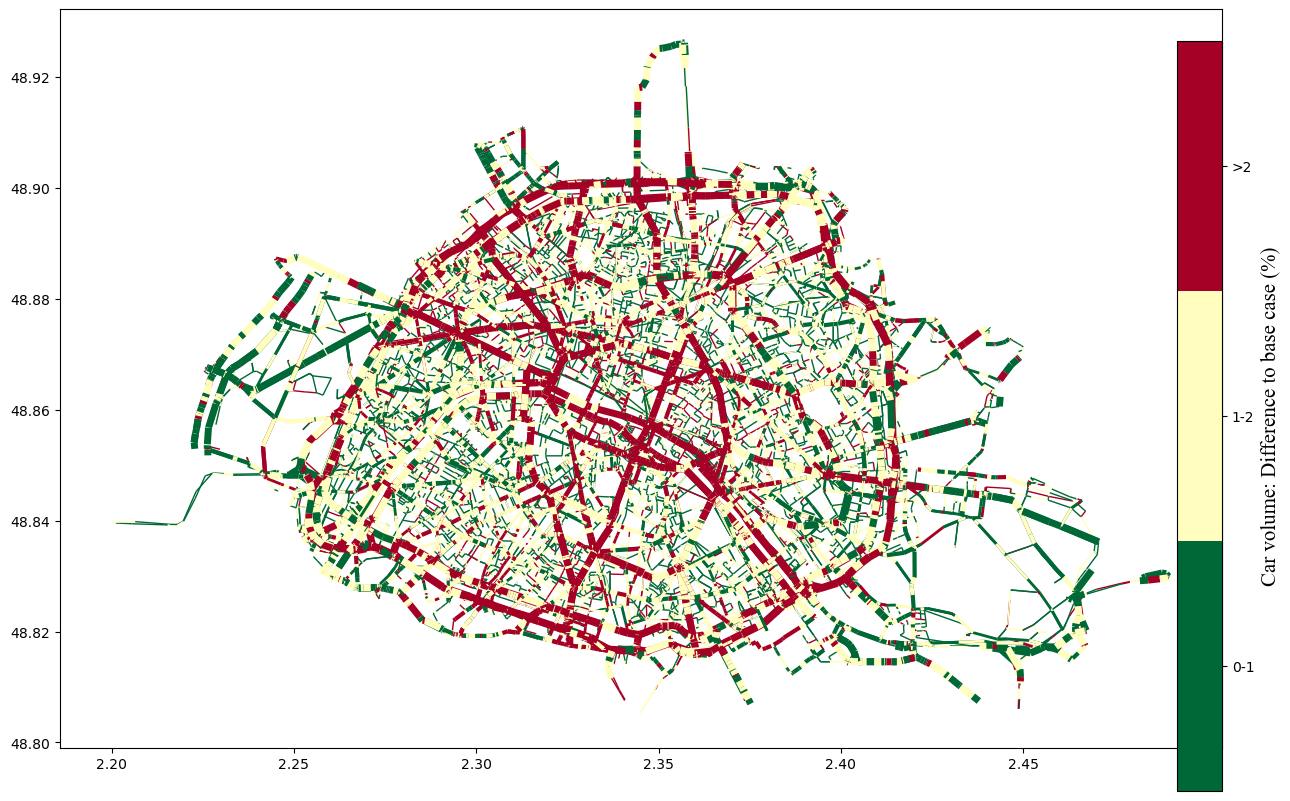

In [13]:
# On the last sample, but does not matter
inversed_x = scaler_x.inverse_transform(test_x)
gdf_with_og_values = hf.data_to_geodataframe_with_og_values(data=test_data, original_gdf=links_base_case, predicted_values=mean_predictions, inversed_x=inversed_x, use_all_features=False)
gdf_with_og_values['capacity_reduction_rounded'] = gdf_with_og_values['capacity_reduction'].round(decimals=3)
gdf_with_og_values['highway'] = gdf_with_og_values['highway'].map(hf.highway_mapping)
gdf_with_og_values['ensemble_uncertainty'] = mean_uncertainties

dicrete_thresholds = [1,2]

hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="ensemble_uncertainty", plot_contour_lines=False,
                        save_it=False, number_to_plot=i+1, zone_to_plot = "this zone", is_predicted=True, use_fixed_norm=False,
                        known_districts = False, buffer = 0.0005, districts_of_interest=None, scale_type='discrete', discrete_thresholds=dicrete_thresholds)